In [1]:
from temp_mesmer import Mesmer


In [2]:
# from deepcell.datasets import TissueNet
import os
import numpy as np
import torch
import torch.nn as nn
from torchinfo import summary
import matplotlib.pyplot as plt
import time

from tqdm import tqdm

In [3]:
from temp_panoptic import PanopticNet

In [4]:
# from deepcell.applications.mesmer import mesmer_preprocess
from temp_mesmer import mesmer_preprocess
# from deepcell import image_generators
from temp_iter_semantic import SemanticDataGenerator
from temp_iter_cropping import CroppingDataGenerator

In [5]:
for i in range(torch.cuda.device_count()):
   print(torch.cuda.get_device_properties(i).name)

NVIDIA RTX A6000
NVIDIA RTX A6000


In [6]:
torch.cuda.empty_cache()
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device_ids = [0, 1]
print(device)

cuda:0


In [7]:
# # Only use if saved data gets deleted
# tissuenet = TissueNet(version='1.1')
# X_train, y_train, meta_train = tissuenet.load_data(split='train')
# X_val, y_val, meta_val = tissuenet.load_data(split='val')
# X_test, y_test, meta_test = tissuenet.load_data(split='test')

In [8]:
tissuenet_dir = "/data/tissuenet"
if not os.path.exists(tissuenet_dir):
    print("Created tissuenet data dir")
    os.makedirs(tissuenet_dir)

print(os.listdir("/data"))
print(os.listdir(tissuenet_dir))

['saved_model_full_gen_8.pth', 'saved_model_full_gen_8_epoch20.pth', 'saved_model_full_gen_8_epoch40.pth', 'saved_model_full_gen_8_epoch60.pth', 'saved_model_full_gen_8_epoch80.pth', 'saved_model_full_gen_8_epoch100.pth', 'tissuenet', 'saved_model_40.pth', 'saved_model_full_gen_8_epoch10.pth', 'saved_model_full_gen_8_epoch30.pth', 'saved_model_full_gen_8_epoch50.pth', 'saved_model_full_gen_8_epoch70.pth', 'saved_model_full_gen_8_epoch90.pth']
['train.npz', 'val_256x256.npz', 'test_256x256.npz', 'train_limited.npz']


In [9]:
def load_data(filepath):
    """Load train, val, and test data"""
    X_train, y_train = _load_npz(os.path.join(filepath, "train.npz"))

    X_val, y_val = _load_npz(os.path.join(filepath, "val_256x256.npz"))

    return (X_train, y_train), (X_val, y_val)

In [10]:
def _load_npz(filepath):
    """Load a npz file"""
    data = np.load(filepath)
    X = data["X"]
    y = data["y"]

    print(
        "Loaded {}: X.shape: {}, y.shape {}".format(
            os.path.basename(filepath), X.shape, y.shape
        )
    )

    return X, y

In [11]:
from deepcell_toolbox.metrics import Metrics
from scipy.stats import hmean


def evaluate(y_pred, y_test):
    m = Metrics("DVC Mesmer")
    metrics = m.calc_object_stats(y_test, y_pred)

    # calculate image-level recall and precision for F1 score
    recall = metrics["correct_detections"].values / metrics["n_true"].values
    recall = np.where(np.isfinite(recall), recall, 0)

    precision = metrics["correct_detections"] / metrics["n_pred"]
    precision = np.where(np.isfinite(precision), precision, 0)
    f1 = hmean([recall, precision])

    # record summary stats
    summary = m.summarize_object_metrics_df(metrics)

    valid_keys = {
        "recall",
        "precision",
        "jaccard",
        "n_true",
        "n_pred",
        "gained_detections",
        "missed_detections",
        "split",
        "merge",
        "catastrophe",
    }

    output_data = {}
    for k in valid_keys:
        if k in {"jaccard", "recall", "precision"}:
            output_data[k] = float(summary[k])
        else:
            output_data[k] = int(summary[k])
    output_data["f1"] = float(np.mean(f1))

    return output_data


In [12]:
def weighted_categorical_crossentropy(y_true, y_pred, device,
                                      n_classes=3, axis=None,
                                      from_logits=False):
    """Categorical crossentropy between an output tensor and a target tensor.
    Automatically computes the class weights from the target image and uses
    them to weight the cross entropy

    Args:
        y_true: A tensor of the same shape as ``y_pred``.
        y_pred: A tensor resulting from a softmax
            (unless ``from_logits`` is ``True``, in which
            case ``y_pred`` is expected to be the logits).
        from_logits: Boolean, whether ``y_pred`` is the
            result of a softmax, or is a tensor of logits.

    Returns:
        tensor: Output tensor.
    """
    if from_logits:
        raise Exception('weighted_categorical_crossentropy cannot take logits')
    y_true = torch.tensor(y_true).to(device)
    # y_true = K.cast(y_true, y_pred.dtype)
    # n_classes = K.cast(n_classes, y_pred.dtype)
    if axis is None:
        axis = 1 # if K.image_data_format() == 'channels_first' else K.ndim(y_pred) - 1
    reduce_axis = [x for x in list(range(torch.Tensor.dim(y_pred))) if x != axis]
    # scale preds so that the class probas of each sample sum to 1
    y_pred = y_pred / torch.sum(y_pred, dim=axis, keepdims=True)
    # manual computation of crossentropy
    eps=1e-10
    _epsilon = torch.tensor(eps).type(y_pred.dtype).to(device)#.base_dtype)
    y_pred = torch.clamp(y_pred, min=_epsilon, max=(1. - _epsilon))
    total_sum = torch.sum(y_true)
    class_sum = torch.sum(y_true, dim=reduce_axis, keepdims=True)
    class_weights = 1.0 / n_classes * torch.divide(total_sum, class_sum + 1.)
    return - torch.sum((y_true * torch.log(y_pred) * class_weights), dim=axis)


In [13]:
def semantic_loss(n_classes):
    def _semantic_loss(y_pred, y_true):
        
        y_pred_device = y_pred.device
        if n_classes > 1:
            tmp_loss = 0.01 * weighted_categorical_crossentropy(y_true, y_pred, y_pred_device, n_classes=n_classes)
            return torch.mean(tmp_loss)
        else:
            loss = nn.MSELoss()
            tmp_loss = loss(y_pred, torch.Tensor(y_true).to(y_pred_device))
            return tmp_loss

    return _semantic_loss

In [14]:
def create_model(input_shape=(256, 256, 2), backbone="resnet50", lr=1e-4):
    num_semantic_classes=[
            1,
            3,
            1,
            3,
        ] # inner distance, pixelwise, inner distance, pixelwise
    
    model = PanopticNet(
        backbone=backbone,
        input_shape=input_shape,
        norm_method=None,
        num_semantic_heads=4,
        num_semantic_classes=num_semantic_classes,
        location=True,  # should always be true
        include_top=True,
    )

    loss = []
    for n_class in num_semantic_classes:
        loss.append(semantic_loss(n_class))

    # optimizer = Adam(lr=lr, clipnorm=0.001)
    # Figure out how to clipnorm

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # model.compile(loss=loss, optimizer=optimizer)

    # print(summary(model, input_size=(4, 2, 256, 256)))

    return model, loss, optimizer

In [15]:
# instantiate model
crop_size = 256
backbone = 'resnet50'
lr = 0.0001
model, losses, optimizer = create_model(
    input_shape=(crop_size, crop_size, 2),
    backbone=backbone,
    lr=lr,
)
count = 0
for module in model.modules():
    if isinstance(module, torch.nn.modules.BatchNorm2d):
        count+=1
        # module.track_running_stats=False
print(count)
count = 0
for module in model.modules():
    if isinstance(module, torch.nn.modules.Dropout):
        count+=1
print(count)
count = 0
for module in model.modules():
    if isinstance(module, torch.nn.Dropout):
        count+=1
print(count)

channels_first
Using ImageNet
conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc
size of all 5
['P7', 'P6', 'P5', 'P4', 'P3']
57
0
0


In [16]:
def create_data_generators(
    train_dict,
    val_dict,
    rotation_range=180,
    shear_range=0,
    zoom_min=0.7,
    horizontal_flip=True,
    vertical_flip=True,
    crop_size=(256, 256),
    seed=0,
    batch_size=8,
    min_objects=0,
):
    # use augmentation for training but not validation
    datagen = CroppingDataGenerator(
        rotation_range=rotation_range,
        shear_range=shear_range,
        zoom_range=(zoom_min, 1 / zoom_min),
        horizontal_flip=horizontal_flip,
        vertical_flip=vertical_flip,
        crop_size=(crop_size, crop_size),
    )

    datagen_val = SemanticDataGenerator(
        rotation_range=0,
        shear_range=0,
        zoom_range=0,
        horizontal_flip=0,
        vertical_flip=0,
    )

    train_data = datagen.flow(
        train_dict,
        seed=seed,
        transforms=["inner-distance", "pixelwise"],
        transforms_kwargs={
            "pixelwise": {"dilation_radius": 1},
            "inner-distance": {"erosion_width": 1, "alpha": "auto"},
        },
        min_objects=0,
        batch_size=batch_size,
    )

    val_data = datagen_val.flow(
        val_dict,
        seed=seed,
        transforms=["inner-distance", "pixelwise"],
        transforms_kwargs={
            "pixelwise": {"dilation_radius": 1},
            "inner-distance": {"erosion_width": 1, "alpha": "auto"},
        },
        min_objects=min_objects,
        batch_size=batch_size,
    )

    return train_data, val_data


In [17]:
seed = 0
zoom_min = 0.75
batch_size = 8

In [18]:
(X_train, y_train), (X_val, y_val) = load_data(tissuenet_dir)
X_test, y_test = _load_npz(os.path.join(tissuenet_dir, "test_256x256.npz"))
smaller = None
smaller_test = None

Loaded train.npz: X.shape: (2580, 512, 512, 2), y.shape (2580, 512, 512, 2)
Loaded val_256x256.npz: X.shape: (3118, 256, 256, 2), y.shape (3118, 256, 256, 2)
Loaded test_256x256.npz: X.shape: (1324, 256, 256, 2), y.shape (1324, 256, 256, 2)


In [19]:
smaller = 40
smaller_test = 20
if smaller:
    X_train, y_train = X_train[:smaller], y_train[:smaller]
    X_val, y_val = X_val[:smaller], y_val[:smaller]
if smaller_test:
    X_test, y_test = X_test[:smaller_test], y_test[:smaller_test]

In [20]:
train_dict = {"X": mesmer_preprocess(X_train), "y": y_train}
val_dict = {"X": mesmer_preprocess(X_val), "y": y_val}

# train_dict = {"X": X_train, "y": y_train}
# val_dict = {"X": X_val, "y": y_val}

In [21]:
print(train_dict["X"].shape)

(40, 512, 512, 2)


In [22]:
train_data, val_data = create_data_generators(
    train_dict,
    val_dict,
    seed=seed,
    zoom_min=zoom_min,
    batch_size=batch_size,
    crop_size=crop_size,
)

In [23]:
def train_one_epoch(model):
    running_loss_avg = 0.
    count = 0

    per_epoch_steps = len(X_train)//batch_size if len(X_train)%batch_size==0 else (len(X_train)//batch_size + 1)
    for _ in tqdm(range(per_epoch_steps)):
        count += 1
        
        li_inputs, li_labels = train_data.next()
        
        inputs = np.transpose(li_inputs, (0, 3, 1, 2))
        labels = [np.transpose(l, (0, 3, 1, 2)) for l in li_labels]

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = sum([losses[j](outputs[j], labels[j]) for j in range(len(losses))])
            
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.001, error_if_nonfinite=True)
    
        optimizer.step()

        running_loss_avg += loss.item()
        
    return running_loss_avg/count

In [24]:
# for param in model.parameters():
#     param.requires_grad=True

In [25]:
loss_tracking = []
vloss_tracking = []
decay_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.99)
plateau_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.33, patience=5,)

In [26]:
start = time.time()
end = time.time()

epoch_number = 0
start_epoch = 0
EPOCHS = 3

best_vloss = 1_000_000.

model = model.to(device)


save_path_prefix = "/data/saved_model"
if smaller is None:
    save_path_prefix = save_path_prefix + "_full_gen_8"
else:
    save_path_prefix = save_path_prefix + "_" + str(smaller)

for epoch in range(start_epoch, EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))
    print("TRAIN")
    model.train(True)
    avg_loss = train_one_epoch(model)
    count = 0
    
    running_vloss_avg = 0.
    
    print("VAL")
    model.eval()

    per_epoch_steps = len(X_val)//batch_size if len(X_val)%batch_size==0 else (len(X_val)//batch_size + 1)
    with torch.no_grad():
        for _ in tqdm(range(per_epoch_steps)):
            count += 1
            
            li_inputs, li_labels = val_data.next()

            vinputs = np.transpose(li_inputs, (0, 3, 1, 2))
            vlabels = [np.transpose(l, (0, 3, 1, 2)) for l in li_labels]
            
            voutputs = model(vinputs)
            
            vloss = sum([losses[j](voutputs[j], vlabels[j]) for j in range(len(losses))])
                
            running_vloss_avg += vloss
                
    avg_vloss = running_vloss_avg/count

    decay_scheduler.step()
    plateau_scheduler.step(avg_vloss)
    print(decay_scheduler.get_last_lr())
    
    loss_tracking.append(avg_loss)
    vloss_tracking.append(avg_vloss)
    
#     # Save model periodically
#     if (epoch+1)%10==0:
#         epoch_path_prefix = save_path_prefix + "_epoch" + str(epoch+1)
#         dict_save_path = epoch_path_prefix + "_dict.pth"
#         save_path = epoch_path_prefix + ".pth"
        
#         # torch.save(model.state_dict(), dict_save_path)
#         torch.save(model, save_path)
    
    if avg_vloss<best_vloss:
        best_vloss = avg_vloss
        dict_save_path = save_path_prefix + "_dict.pth"
        save_path = save_path_prefix + ".pth"
        
        # torch.save(model.state_dict(), dict_save_path)
        torch.save(model, save_path)
        
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    epoch_number += 1


print("Avg epoch time", (end - start)/EPOCHS)
print("Best validation loss -", best_vloss)

EPOCH 1:
TRAIN


  0%|                                                                                                                                                                                                                                                              | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/deepcell/utils/transform_utils.py:87: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  edge = binary_dilation(edge, selem=dil_strel)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:11<00:00,  2.31s/it]


VAL


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.54it/s]


[9.900000000000001e-05]
LOSS train 0.18556807637214662 valid 0.13325241208076477
EPOCH 2:
TRAIN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]


VAL


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.30it/s]


[9.801e-05]
LOSS train 0.0990855261683464 valid 0.12635569274425507
EPOCH 3:
TRAIN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:10<00:00,  2.15s/it]


VAL


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.61it/s]


[9.70299e-05]
LOSS train 0.07825172841548919 valid 0.11517062038183212
Avg epoch time 7.708867390950521e-06
Best validation loss - tensor(0.1152, device='cuda:0')


In [27]:
# model, _, _ = create_model(
#     input_shape=(crop_size, crop_size, 2),
#     backbone=backbone,
#     lr=lr,
# )
# model.load_state_dict(torch.load("/data/saved_model_dict.pth", map_location=device, weights_only=True))

model = torch.load("/data/saved_model_40.pth", weights_only=False)

In [28]:
# cpu_device = torch.device("cuda:0")
cpu_device = device
cpu_model = model.to(cpu_device)
cpu_model.device = cpu_device
cpu_model.eval()
app = Mesmer(cpu_model)

In [29]:
cell_preds = app.predict(X_test, batch_size=16)

whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}


/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


(256, 256, 2)
whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}


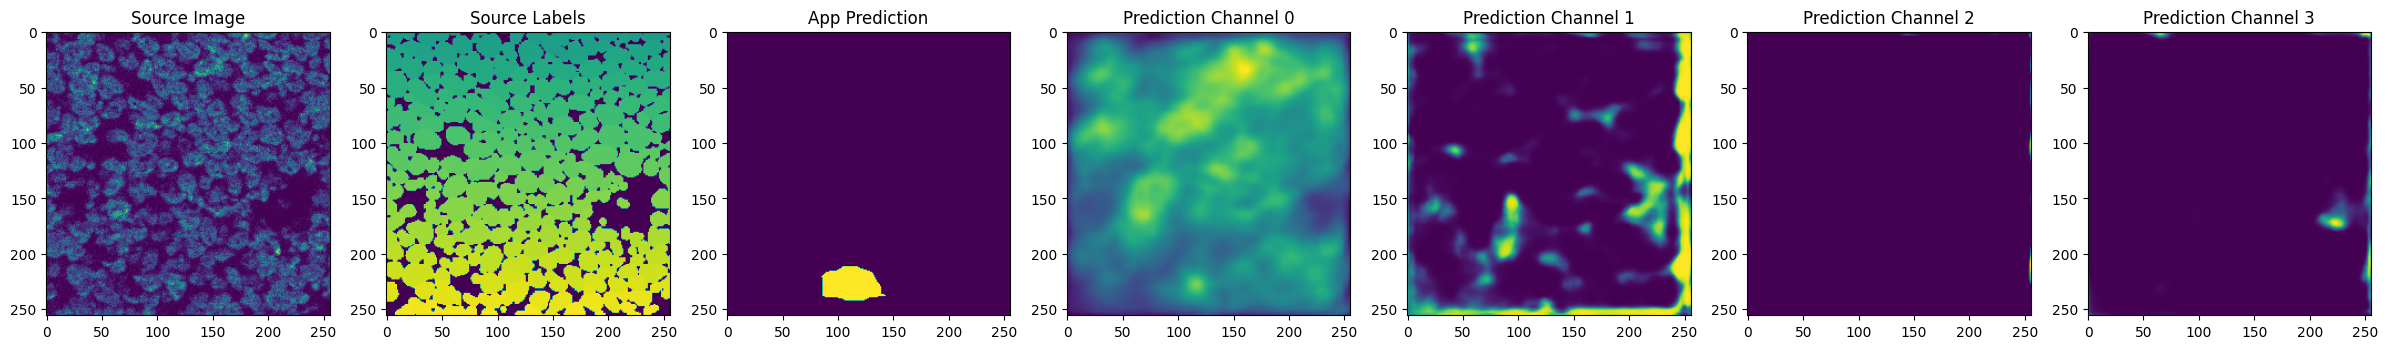

In [30]:
idx = 2
img, lab = X_test[idx].astype(np.float32), y_test[idx]
print(img.shape)

cell_pred = app.predict(np.expand_dims(img, axis=0),)
pred = cpu_model.predict(np.expand_dims(img, axis=0), batch_size=len(img))
fig, axes = plt.subplots(1, 7, figsize=(30, 15))

axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(lab[ ..., 0])
axes[1].set_title('Source Labels')

axes[2].imshow(cell_pred[0, ...])
axes[2].set_title('App Prediction')

axes[3].imshow(pred[0].cpu().detach().numpy()[0, ..., 0])
axes[3].set_title('Prediction Channel 0')

axes[4].imshow(pred[1].cpu().detach().numpy()[0, ..., 0])
axes[4].set_title('Prediction Channel 1')

axes[5].imshow(pred[2].cpu().detach().numpy()[0, ..., 0])
axes[5].set_title('Prediction Channel 2')

axes[6].imshow(pred[3].cpu().detach().numpy()[0, ..., 2])
axes[6].set_title('Prediction Channel 3')


plt.show()

In [31]:
nuc_preds = app.predict(X_test, compartment="nuclear")
nuc_metrics = evaluate(nuc_preds, y_test[..., 1:])

whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 19.35it/s]


____________Object-based statistics____________

Number of true cells:		 3056
Number of predicted cells:	 345

Correct detections:  15	Recall: 0.0049%
Incorrect detections: 330	Precision: 0.0435%


Gained detections: 57	Perc Error 9.8616%
Missed detections: 248	Perc Error 42.9066%
Splits: 0		Perc Error 0.0%
Merges: 269		Perc Error 46.5398%
Catastrophes: 4		Perc Error 0.692%
Gained detectionsfrom split: 0
Missed detectionsfrom merge: 2516
True detectionsin catastrophe: 12
Pred detectionsin catastrophe: 8
SEG: nan 

Average Pixel IOU (Jaccard Index): 0.4408 




/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/metrics.py:1098: UserWarning: Provided data is being relabeled. Cell ids from metrics will not match cell ids in original data. Relabel your data prior to running the metrics package if you wish to maintain cell ids. 
  warnings.warn(


In [32]:
cell_metrics = evaluate(cell_preds, y_test[..., :1])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:01<00:00, 14.58it/s]


____________Object-based statistics____________

Number of true cells:		 3562
Number of predicted cells:	 390

Correct detections:  82	Recall: 0.023%
Incorrect detections: 308	Precision: 0.2103%


Gained detections: 39	Perc Error 10.9859%
Missed detections: 47	Perc Error 13.2394%
Splits: 0		Perc Error 0.0%
Merges: 247		Perc Error 69.5775%
Catastrophes: 22		Perc Error 6.1972%
Gained detectionsfrom split: 0
Missed detectionsfrom merge: 2868
True detectionsin catastrophe: 340
Pred detectionsin catastrophe: 44
SEG: nan 

Average Pixel IOU (Jaccard Index): 0.6629 




/usr/local/lib/python3.8/dist-packages/deepcell_toolbox/metrics.py:1098: UserWarning: Provided data is being relabeled. Cell ids from metrics will not match cell ids in original data. Relabel your data prior to running the metrics package if you wish to maintain cell ids. 
  warnings.warn(


In [33]:
# cell_metrics:
#   catastrophe: 824
#   f1: 0.7834164228098235
#   gained_detections: 15714
#   jaccard: 0.8252
#   merge: 3288
#   missed_detections: 20613
#   n_pred: 138995
#   n_true: 145225
#   precision: 0.8222
#   recall: 0.7869
#   split: 2256

In [34]:
inputs, labels = val_data.next()
cpu_model.eval()
cpu_app = Mesmer(cpu_model)
app_output = cpu_app.predict(inputs)


[print(labels[i].shape) for i in range(len(labels))]

img = inputs[0]
outputs = [i.cpu().detach().numpy() for i in cpu_model.predict(inputs, len(img))]

o_1 = outputs[0]
o_2 = outputs[1]
o_3 = outputs[2]
o_4 = outputs[3]

ch_1 = labels[0]
ch_2 = labels[1]
ch_3 = labels[2]
ch_4 = labels[3]



/usr/local/lib/python3.8/dist-packages/deepcell/utils/transform_utils.py:87: FutureWarning: `selem` is a deprecated argument name for `binary_dilation`. It will be removed in version 1.0. Please use `footprint` instead.
  edge = binary_dilation(edge, selem=dil_strel)


whole-cell
nuclear
{'maxima_threshold': 0.075, 'maxima_smooth': 0, 'interior_threshold': 0.2, 'interior_smooth': 2, 'small_objects_threshold': 15, 'fill_holes_threshold': 15, 'radius': 2}
(8, 256, 256, 1)
(8, 256, 256, 3)
(8, 256, 256, 1)
(8, 256, 256, 3)


/usr/local/lib/python3.8/dist-packages/skimage/_shared/utils.py:157: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  return func(*args, **kwargs)


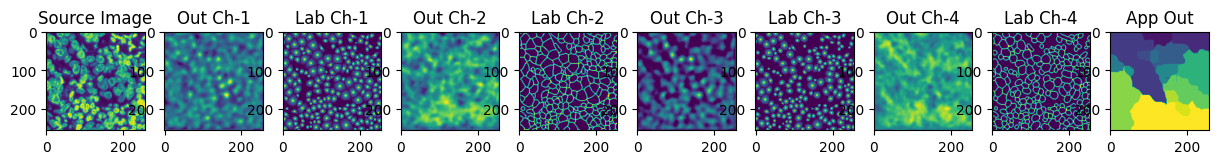

In [35]:
fig, axes = plt.subplots(1, 10, figsize=(15, 15))


axes[0].imshow(img[..., 0])
axes[0].set_title('Source Image')

axes[1].imshow(o_1[0, ..., 0])
axes[1].set_title('Out Ch-1')

axes[2].imshow(ch_1[0, ..., 0])
axes[2].set_title('Lab Ch-1')

axes[3].imshow(o_2[0, ..., 0])
axes[3].set_title('Out Ch-2')

axes[4].imshow(ch_2[0, ..., 0])
axes[4].set_title('Lab Ch-2')

axes[5].imshow(o_3[0, ..., 0])
axes[5].set_title('Out Ch-3')

axes[6].imshow(ch_3[0, ..., 0])
axes[6].set_title('Lab Ch-3')

axes[7].imshow(o_4[0, ..., 0])
axes[7].set_title('Out Ch-4')


axes[8].imshow(ch_4[0, ..., 0])
axes[8].set_title('Lab Ch-4')

axes[9].imshow(app_output[0, ..., 0])
axes[9].set_title('App Out')

plt.show()


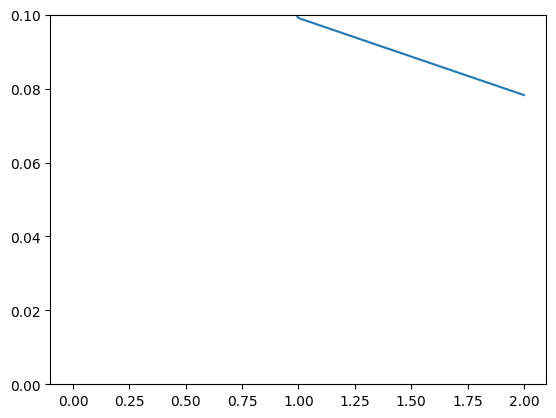

In [36]:
vloss_tracking_cpu = [i.cpu() for i in vloss_tracking]
plt.plot(loss_tracking)
plt.plot(vloss_tracking_cpu)
ax = plt.gca()
ax.set_ylim([0, 0.1])

plt.show()